In [67]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm

starry.config.quiet = True
np.random.seed(1)

In [68]:
starry.config.lazy = False
starry.config.quiet = True

In [69]:
t = np.linspace(0, 10, 1000)

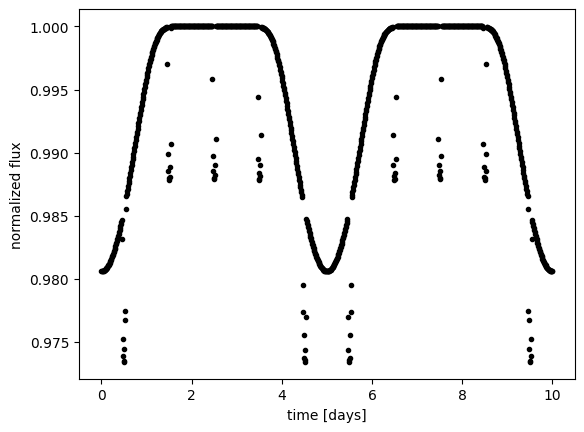

In [70]:
map = starry.Map(ydeg=15, udeg=2)
contrast = 0.25
radius = 15
map.spot(contrast=contrast, radius=radius)

rp_true = 0.1
porb = 1. 
t0 = 0.5
mp = 6e-4
ecc=0.0
u1 = 0.40
u2 = 0.26
prot = 5

star = starry.Primary(map, m=1.0, r=1.0, prot=prot)
star.map[1] = u1
star.map[2] = u2

planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=mp,  # mass in solar masses
    r=rp_true,  # radius in solar radii
    porb=porb,  # orbital period in days
    ecc=ecc,  # eccentricity
    t0=t0,  # time of transit in days
)
system = starry.System(star, planet)

flux_star, flux_planet = system.flux(t, total=False)

plt.plot(t, flux_star, 'k.')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.show()

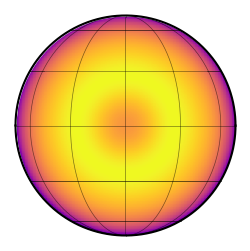

In [71]:
map.show()

In [72]:
xo, yo, zo = system.position(t)
xo = xo[1]
yo = yo[1]
zo = zo[1]

In [73]:
theta = (360 * t / 10.0) % 360

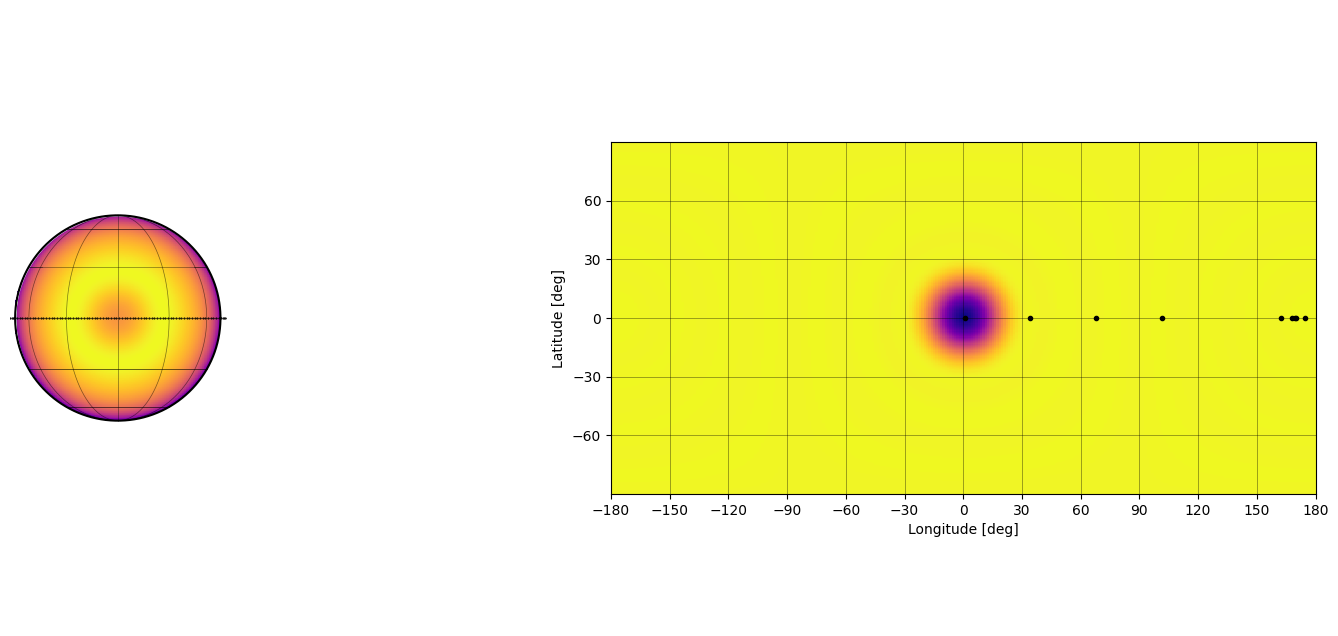

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
# map[:, :] = y
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

In [75]:
ferr = 1e-6
err = np.ones_like(flux_star) * ferr
noise = np.random.randn(len(t)) * err
flux_true = flux_star + noise

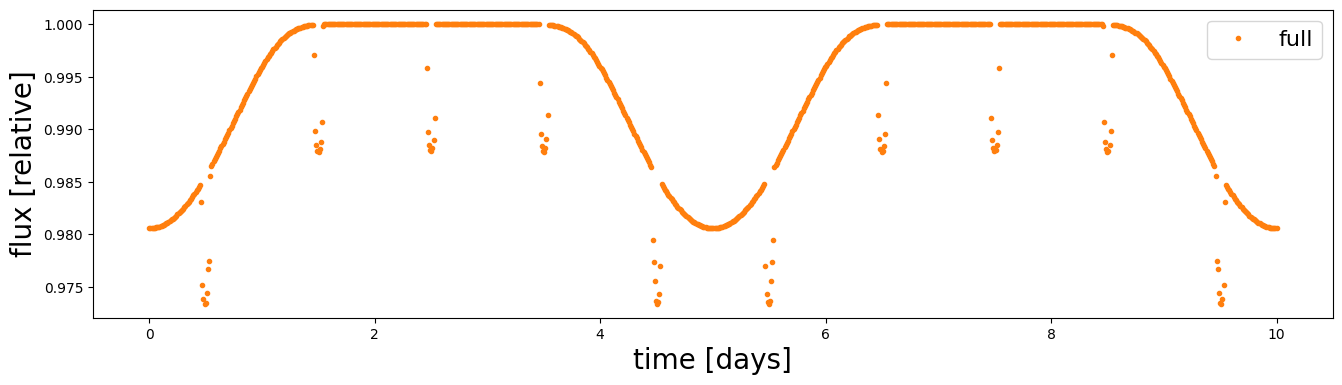

In [76]:
# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux_true, "C1.", alpha=1, label="full")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [77]:
A = map.design_matrix(
    theta=theta, xo=xo, yo=yo, zo=zo, ro=rp_true
)

# *** Draw 1 sample from the GP
sp = StarryProcess(
    r=15,
    c=0.25,
    n=1,
    mu=0,
    sigma=1,
    marginalize_over_inclination=False,  
    normalized=False,
)

Sigma_s = sp.cov_ylm 
mu_ylm = sp.mean_ylm
# mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
mu_flux = tt.dot(A, mu_ylm) #/ norm
K = len(t)

U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
# log_sigmadet -= 2*256*tt.log(norm)

r = tt.as_tensor_variable(flux_true) - mu_flux
v = tt.dot(A.T,(r/tt.square(err)))
Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

loglike = -0.5 * Q
loglike -= 0.5  * log_sigmadet
loglike -= 0.5 * K * tt.log(2 * np.pi)

In [78]:
loglike.eval()

array(-2.71895683e+11)

In [80]:
y = sp.sample_ylm_conditional(t=t, flux=flux_true, data_cov=err**2, nsamples=1, A=A, p=prot, baseline_mean=1).eval().reshape(-1)

In [81]:
map_samp = starry.Map(ydeg=15, udeg=2)
map_samp[:,:] = y

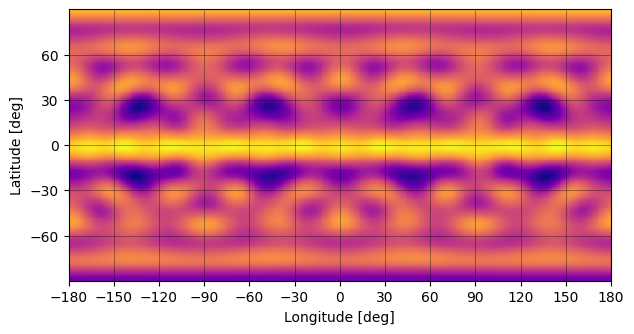

In [82]:
map_samp.show(projection="rect")

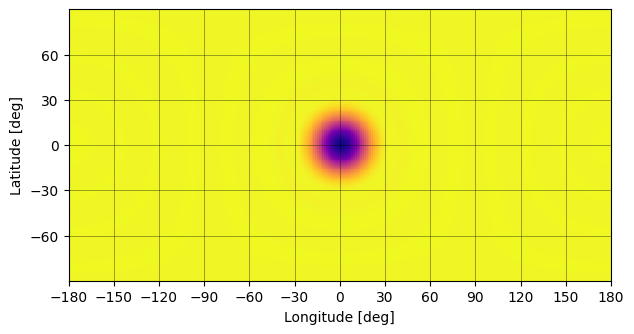

In [83]:
map.show(projection="rect")

In [18]:
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=2)

In [19]:
ny = len(map.y)
npix = lat.shape[0]

In [84]:
with pm.Model() as model:
    starry.config.lazy = True

    # *** Draw 1 sample from the GP
    sp = StarryProcess(
        r=15,
        c=0.25,
        n=1,
        marginalize_over_inclination=False,  
        normalized=False,
    )

    y = sp.sample_ylm_conditional(t=t, flux=flux_true, data_cov=err**2, nsamples=1, A=A, p=30)

    pm.Deterministic("y", y)

    # Compute the flux
    map_model = starry.Map(ydeg=15, udeg=2)
    map_model[:,:] = y.eval().reshape(-1)
    
    rp = pm.Uniform('rp',lower=0.099, upper=0.11)
    porb = pm.Uniform('porb',lower=0.999999, upper=1.00000001)
    t0 = pm.Uniform("t0",lower=0.499999, upper=0.50000001)
    mp = pm.Uniform('mp',lower=5.9e-4, upper=6.1e-4)
    ecc=0.0
    u1 = pm.Uniform('u1',lower=0.3, upper=0.5)
    u2 = pm.Uniform('u2',lower=0.25, upper=0.27)
    # prot = pm.Uniform('prot',lower=9, upper=11)

    a = starry.Primary(map_model, m=1.0, r=1.0, prot=prot)
    a.map[1] = u1
    a.map[2] = u2

    b = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=mp,  # mass in solar masses
        r=rp,  # radius in solar radii
        porb=porb,  # orbital period in days
        ecc=ecc,  # eccentricity
        t0=t0,  # time of transit in days
    )
    sys = starry.System(a, b)

    flux_model, flux_p = sys.flux(t, total=False)

    pm.Deterministic("lc_model", flux_model)


    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ferr, observed=flux_star)


    Sigma_s = sp.cov_ylm 
    pm.Deterministic("cov", Sigma_s)

In [85]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y = np.array(soln["y"])
    cov = soln["cov"]
    flux_model = soln["lc_model"]

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fac1d74a130>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fac1d74a130>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fac1d74a130>.1

message: Desired error not necessarily achieved due to precision loss.
logp: -31869329592.276314 -> -30017540751.165886


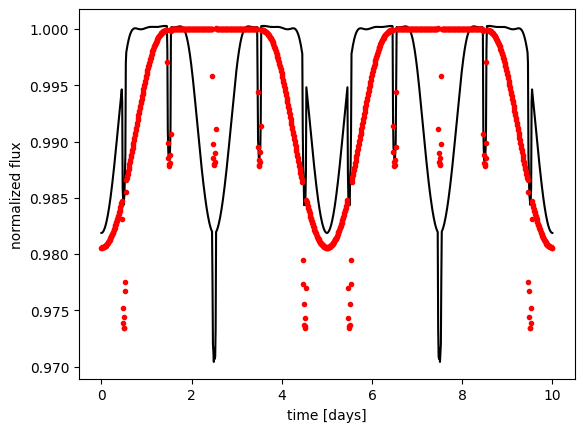

In [86]:
plt.plot(t, flux_model, 'k')
plt.plot(t, flux_star, 'r.')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.show()


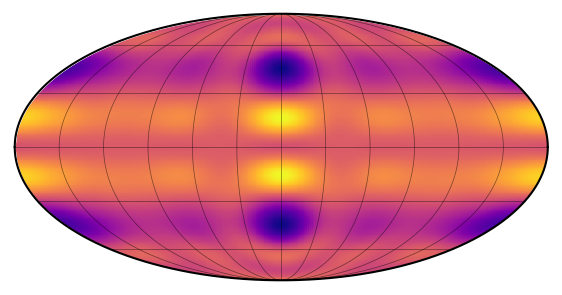

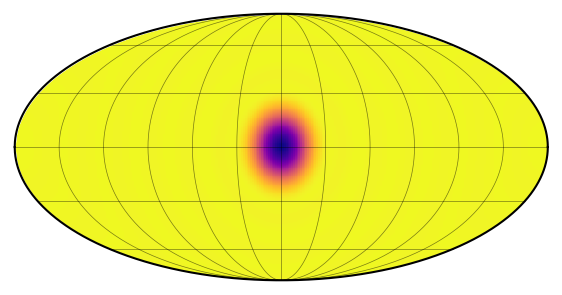

In [87]:
map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = y.reshape(-1)
map_inf.show(projection="moll")
map.show(projection="moll")


Text(0, 0.5, 'flux')

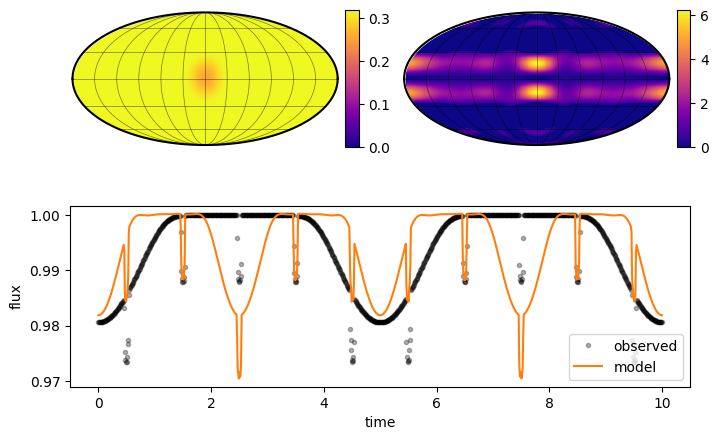

In [88]:
from matplotlib import colors
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.15)
ax = [
    plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1),
]

# Show the true map
map.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
    norm=cnorm()
)

# Show the inferred map
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
    norm=cnorm()
)

# Show the flux model
ax[2].plot(t, flux_true, "k.", alpha=0.3, label="observed")
ax[2].plot(t, flux_model, "C1", label="model")
ax[2].legend(fontsize=10, loc="lower right")
ax[2].set_xlabel("time")
ax[2].set_ylabel("flux")